In [ ]:
%pip install librosa
%pip install tensorflow

In [3]:
import librosa
import pandas as pd
import os
import requests
import torch
from torch.utils.data import Dataset, DataLoader
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from typing import Union
from sklearn.metrics import confusion_matrix
import seaborn as sns



In [4]:
LINK = 'https://github.com/Jakobovski/free-spoken-digit-dataset.git'
FOLDER_AUDIOS = 'free-spoken-digit-dataset/recordings'
LOCAL_DIR = r'C:\Users\larissa.silva\Documents\UFRN\2023.2\DL\espectrogramas'

### Getting and Transforming Data

In [4]:
!git clone https://github.com/Jakobovski/free-spoken-digit-dataset.git

def get_data(folder)->str:
  """
    Função responsável por receber um caminho do link do github até a pasta
    e devolver uma lista com os nomes dos arquivos de interesse e as respectivas
    labels.
    Args:
      - folder(str): caminho da pasta com os arquivos desejados.
    Return:
      - file_names(list): lista com o nome dos arquivos.
      - labels(list): lista com label de cada áudio, respeitando a ordem.
  """
  # Listar os arquivos no diretório clonado
  os.listdir(folder)

  # Diretório onde os arquivos estão clonados
  data_folder = folder

  # Listar todos os arquivos no diretório
  file_names = os.listdir(data_folder)

  # Iterar sobre os arquivos
  for file_name in file_names:
      file_path = os.path.join(data_folder, file_name)
      # Carregar o áudio com librosa ou realizar outras operações conforme necessário
      audio, sr = librosa.load(file_path, duration=3, sr=22050)

  labels = [int(file.split('_')[0]) for file in file_names]

  return file_names, labels

file_names, labels = get_data(FOLDER_AUDIOS)

fatal: destination path 'free-spoken-digit-dataset' already exists and is not an empty directory.


In [5]:
df_FDD = pd.DataFrame({
    'file_path': file_names,
    'label': labels
})

df_FDD.head()


,file_path,label
0,0_george_0.wav,0
1,0_george_1.wav,0
2,0_george_10.wav,0
3,0_george_11.wav,0
4,0_george_12.wav,0


#### Turning audio into spectograms

In [ ]:
# Pasta para salvar os espectrogramas
output_folder = "espectrogramas"
os.makedirs(output_folder, exist_ok=True)

# Listar todos os arquivos no diretório
file_names = os.listdir(FOLDER_AUDIOS)

# Iterar sobre os arquivos
for file_name in file_names:
    file_path = os.path.join(FOLDER_AUDIOS, file_name)
    # Carregar o áudio com librosa
    audio, sr = librosa.load(file_path, duration=3, sr=22050) # limitar a 0.5 segundos e usar conv2d

    # Calcular o espectrograma
    D = librosa.amplitude_to_db(np.abs(librosa.stft(audio)), ref=np.max)

    # Plotar e salvar o espectrograma como imagem
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Espectrograma')
    spec_path = os.path.join(output_folder, f"{file_name.split('.')[0]}.png")
    plt.savefig(spec_path)
    plt.close()

#### Database's owner transformation functions

In [ ]:
from __future__ import division, print_function
import os
from os import listdir
from os.path import isfile, join

from matplotlib import pyplot as plt
import scipy.io.wavfile as wav


def wav_to_spectrogram(audio_path, save_path, spectrogram_dimensions=(64, 64), noverlap=16, cmap='gray_r'):
    """ Creates a spectrogram of a wav file.

    :param audio_path: path of wav file
    :param save_path:  path of spectrogram to save
    :param spectrogram_dimensions: number of pixels the spectrogram should be. Defaults (64,64)
    :param noverlap: See http://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.spectrogram.html
    :param cmap: the color scheme to use for the spectrogram. Defaults to 'gray_r'
    :return:
    """

    sample_rate, samples = wav.read(audio_path)

    fig = plt.figure()
    fig.set_size_inches((spectrogram_dimensions[0]/fig.get_dpi(), spectrogram_dimensions[1]/fig.get_dpi()))
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    ax.specgram(samples, cmap=cmap, Fs=2, noverlap=noverlap)
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())
    fig.savefig(save_path, bbox_inches="tight", pad_inches=0)
    
def dir_to_spectrogram(audio_dir, spectrogram_dir, spectrogram_dimensions=(64, 64), noverlap=16, cmap='gray_r'):
    """ Creates spectrograms of all the audio files in a dir

    :param audio_dir: path of directory with audio files
    :param spectrogram_dir: path to save spectrograms
    :param spectrogram_dimensions: tuple specifying the dimensions in pixes of the created spectrogram. default:(64,64)
    :param noverlap: See http://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.spectrogram.html
    :param cmap: the color scheme to use for the spectrogram. Defaults to 'gray_r'
    :return:
    """
    file_names = [f for f in listdir(audio_dir) if isfile(join(audio_dir, f)) and '.wav' in f]

    for file_name in file_names:
        print(file_name)
        audio_path = audio_dir + file_name
        spectogram_path = spectrogram_dir + file_name.replace('.wav', '.png')
        wav_to_spectrogram(audio_path, spectogram_path, spectrogram_dimensions=spectrogram_dimensions, noverlap=noverlap, cmap=cmap)


if __name__ == '__main__':
    audio_dir = "./recordings/"
    spectrogram_dir = "./spectrograms/"
    dir_to_spectrogram(audio_dir, spectrogram_dir)

##### Adding images path into DF

In [6]:
images_path = []
for path_img in os.listdir('./espectrogramas/'):
    images_path.append(path_img)

df_FDD['image_path'] = images_path

##### Saving DF as CSV file

In [7]:
df_FDD.to_csv('df_FDD.csv', index=False)

### Setting train, test and validation sets

In [99]:
df_FDD = pd.read_csv('df_FDD.csv')
df_FDD

,Unnamed: 0,file_path,label,image_path
0,0,0_george_0.wav,0,0_george_0.png
1,1,0_george_1.wav,0,0_george_1.png
2,2,0_george_10.wav,0,0_george_10.png
3,3,0_george_11.wav,0,0_george_11.png
4,4,0_george_12.wav,0,0_george_12.png
...,...,...,...,...
2995,2995,9_yweweler_5.wav,9,9_yweweler_5.png
2996,2996,9_yweweler_6.wav,9,9_yweweler_6.png
2997,2997,9_yweweler_7.wav,9,9_yweweler_7.png
2998,2998,9_yweweler_8.wav,9,9_yweweler_8.png


In [71]:
train_df, test_df = train_test_split(df_FDD, test_size=0.2, random_state=52, stratify=df_FDD['label'])
val_df, test_df = train_test_split(test_df, test_size=0.5, random_state=52, stratify=test_df['label'])

##### Checking df's info

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2400 entries, 1847 to 950
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   file_path   2400 non-null   object
 1   label       2400 non-null   int64 
 2   image_path  2400 non-null   object
dtypes: int64(1), object(2)
memory usage: 75.0+ KB


In [ ]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 300 entries, 1321 to 2474
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   file_path   300 non-null    object
 1   label       300 non-null    int64 
 2   image_path  300 non-null    object
dtypes: int64(1), object(2)
memory usage: 9.4+ KB


In [ ]:
val_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 300 entries, 2795 to 1478
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   file_path   300 non-null    object
 1   label       300 non-null    int64 
 2   image_path  300 non-null    object
dtypes: int64(1), object(2)
memory usage: 9.4+ KB


### Processing Dataset and Spliting it

In [115]:
import os
import shutil
from sklearn.model_selection import train_test_split

def split_data(dataframe, source_dir, training_directory, val_dir, test_dir, val_size=0.1, test_size=0.2, random_state=42):
    # Criar diretórios se não existirem
    for directory in [training_directory, val_dir, test_dir]:
        os.makedirs(directory, exist_ok=True)

     # Separar os dados em treinamento, validação e teste
    train_df, test_df = train_test_split(dataframe, test_size=test_size, random_state=random_state)
    train_df, val_df = train_test_split(train_df, test_size=val_size / (1 - test_size), random_state=random_state)

    # Corrigir barras invertidas nos caminhos dos arquivos
    train_df['image_path'] = train_df['image_path'].str.replace('/', os.path.sep)
    val_df['image_path'] = val_df['image_path'].str.replace('/', os.path.sep)
    test_df['image_path'] = test_df['image_path'].str.replace('/', os.path.sep)

    # Copiar os arquivos para os diretórios correspondentes
    def copy_files(df, dest_dir):
        for _, row in df.iterrows():
            # Remover a barra invertida extra no início do caminho do arquivo
            file_path = os.path.join(source_dir, row['image_path'].lstrip(os.path.sep))
            dest_path = os.path.join(dest_dir, row['image_path'])
            shutil.copyfile(file_path, dest_path)

    copy_files(train_df, training_directory)
    copy_files(val_df, val_dir)
    copy_files(test_df, test_dir)

source_directory = "./espectrogramas/"  # Atualize para o diretório real
training_directory = "./training-spectrograms/"  # Atualize para o diretório real
validation_directory = "./validation-spectrograms/"  # Atualize para o diretório real
testing_directory = "./testing-spectrograms/"  # Atualize para o diretório real

split_data(df_FDD, source_directory, training_directory, validation_directory, testing_directory)


In [8]:
# SEM MEMÓRIA PRA ESSA

def load_data(dataframe)->Union[np.array, np.array]:
    """
    Função responsável por receber um dataframe processa as imagens endereçadas
        nele em np.arrays (representação matricial da imagem de forma numérica).
    Args:
      - dataframe(pd.DataFrame): DataFrame com os caminhos para as imagens e as 
        labels de cada imagem.
    Return:
      - np.array: np.array com as matrizes das imagens.
      - np.array: np.array com as labels das imagens.
  """
    images = []
    labels = []
    for _, row in dataframe.iterrows():
        image = plt.imread(os.path.join(LOCAL_DIR, row['image_path']))
        label = row['label']
        images.append(image)
        labels.append(label)
    return np.array(images), np.array(labels)

In [ ]:
# X_train, y_train = load_data(train_df)
# X_val, y_val = load_data(val_df)
# X_test, y_test = load_data(test_df)
# X_train = X_train / 255.0
# X_val = X_val / 255.0
# X_test = X_test / 255.0

In [165]:
import os
import numpy as np
from tensorflow.keras.preprocessing import image
from sklearn.model_selection import train_test_split

def load_and_preprocess_image(file_path, label, target_size=(64, 64)):
    # Carregue a imagem
    img = tf.io.read_file(file_path)
    img = tf.image.decode_wav(img, 1)
    img = tf.squeeze(img, axis=-1)
    
    # Redimensione para o tamanho desejado
    img = tf.image.resize(img, target_size)
    
    # Normalização
    img /= 255.0
    
    # Converta o caminho do arquivo para uma string (removendo o argumento 'encoding')
    file_path = tf.strings.as_string(file_path)

    return img, label

# Função para carregar e pré-processar um conjunto de imagens em um diretório
import os
import numpy as np
import tensorflow as tf

import os
import numpy as np
import tensorflow as tf
from tqdm import tqdm

# Função para carregar e pré-processar uma imagem
def load_and_preprocess_image(file_path):
    # Carregando a imagem
    img = tf.io.read_file(file_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.rgb_to_grayscale(img)

    # Normalizando os valores de pixel para o intervalo [0, 1]
    img = tf.image.convert_image_dtype(img, tf.float32)

    # Redimensionando a imagem para a forma desejada
    img = tf.image.resize(img, [64, 64])

    return img

# Função para carregar e pré-processar imagens de um diretório
def load_and_preprocess_images_from_directory(directory):
    images = []
    labels = []

    # Adicionando informações de depuração
    print(f"Processando imagens para o diretório {directory}...")

    for filename in tqdm(os.listdir(directory)):
        img_path = os.path.join(directory, filename)

        try:
            # Carregando e pré-processando a imagem
            img = load_and_preprocess_image(img_path)

            # Extraindo a label do nome do arquivo
            label = int(filename.split('_')[0])

            # Adicionando a imagem e a label às listas
            images.append(img)
            labels.append(label)

        except Exception as e:
            print(f"Erro ao processar {img_path}: {str(e)}")

    print(f"Loaded {len(images)} images.")
    
    # Convertendo as listas em arrays numpy
    return np.array(images), np.array(labels)

    print(f"Loaded {len(images)} images.")
    return np.vstack(images), np.array(labels)


# Defina os diretórios dos conjuntos de treinamento, validação e teste
train_dir = "C:\\Users\\larissa.silva\\Documents\\UFRN\\2023.2\\DL\\training-spectrograms"
val_dir = "C:\\Users\\larissa.silva\\Documents\\UFRN\\2023.2\\DL\\validation-spectrograms"
test_dir = "C:\\Users\\larissa.silva\\Documents\\UFRN\\2023.2\\DL\\testing-spectrograms"

# Carregue e pré-processe os dados de treinamento
X_train, y_train = load_and_preprocess_images_from_directory(train_dir)
X_test, y_test = load_and_preprocess_images_from_directory(train_dir)
X_val, y_val = load_and_preprocess_images_from_directory(train_dir)

# Adicione prints para verificar o que está acontecendo
print("Antes da divisão - X_train shape:", X_train.shape)
print("Antes da divisão - y_train shape:", y_train.shape)

# Adicione um print para verificar os primeiros arquivos no conjunto de treinamento
print("Primerias imagens no conjunto de treinamento:", X_train[:5])

# Divida os dados em treinamento, validação e teste
# Certifique-se de ajustar os parâmetros conforme necessário (test_size, random_state, etc.)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Verifique as formas (shapes) dos seus dados após a divisão
print("Após a divisão - X_train shape:", X_train.shape)
print("Após a divisão - y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)


Processando imagens para o diretório C:\Users\larissa.silva\Documents\UFRN\2023.2\DL\training-spectrograms...


  0%|          | 0/2100 [00:00<?, ?it/s]

100%|██████████| 2100/2100 [00:48<00:00, 43.13it/s]


Loaded 2100 images.
Processando imagens para o diretório C:\Users\larissa.silva\Documents\UFRN\2023.2\DL\training-spectrograms...


100%|██████████| 2100/2100 [00:48<00:00, 43.13it/s]


Loaded 2100 images.
Processando imagens para o diretório C:\Users\larissa.silva\Documents\UFRN\2023.2\DL\training-spectrograms...


100%|██████████| 2100/2100 [00:47<00:00, 43.87it/s]


Loaded 2100 images.
Antes da divisão - X_train shape: (2100, 64, 64, 1)
Antes da divisão - y_train shape: (2100,)
Primerias imagens no conjunto de treinamento: [[[[1.]
   [1.]
   [1.]
   ...
   [1.]
   [1.]
   [1.]]

  [[1.]
   [1.]
   [1.]
   ...
   [1.]
   [1.]
   [1.]]

  [[1.]
   [1.]
   [1.]
   ...
   [1.]
   [1.]
   [1.]]

  ...

  [[1.]
   [1.]
   [1.]
   ...
   [1.]
   [1.]
   [1.]]

  [[1.]
   [1.]
   [1.]
   ...
   [1.]
   [1.]
   [1.]]

  [[1.]
   [1.]
   [1.]
   ...
   [1.]
   [1.]
   [1.]]]


 [[[1.]
   [1.]
   [1.]
   ...
   [1.]
   [1.]
   [1.]]

  [[1.]
   [1.]
   [1.]
   ...
   [1.]
   [1.]
   [1.]]

  [[1.]
   [1.]
   [1.]
   ...
   [1.]
   [1.]
   [1.]]

  ...

  [[1.]
   [1.]
   [1.]
   ...
   [1.]
   [1.]
   [1.]]

  [[1.]
   [1.]
   [1.]
   ...
   [1.]
   [1.]
   [1.]]

  [[1.]
   [1.]
   [1.]
   ...
   [1.]
   [1.]
   [1.]]]


 [[[1.]
   [1.]
   [1.]
   ...
   [1.]
   [1.]
   [1.]]

  [[1.]
   [1.]
   [1.]
   ...
   [1.]
   [1.]
   [1.]]

  [[1.]
   [1.]
   [1.]


In [ ]:
from sklearn.model_selection import train_test_split

indices_train, indices_val = train_test_split(range(len(X_train)), test_size=0.2, random_state=42)
X_val = X_train[indices_val]
y_val = y_train[indices_val]
X_train = X_train[indices_train]
y_train = y_train[indices_train]


In [ ]:
batch_size = 16
train_dataset = create_tf_dataset(train_df, batch_size=batch_size, shuffle=True)
val_dataset = create_tf_dataset(val_df, batch_size=batch_size, shuffle=False)
test_dataset = create_tf_dataset(test_df, batch_size=batch_size, shuffle=False)

In [194]:
def create_cnn_model_with_dropout(input_shape, num_classes, dropout_rate=0.3):
    """
        Cria um modelo CNN para treinar os dados obtidos. Contém 2 camadas convolucionais,
            com 32, 64 respectivamente, todos de tamanho 3x3. Em todas as
            camadas utiliza-se a ReLU. É aplicada uma operação de pooling em todas as camadas
            e um dropout antes da última camada

        Args:
        - input_shape(int): Dimensões do espectograma.
        - num_classes(int): Número de classes na saída.
        - dropout_rate(float): Rate de camadas zeradas na camada anterior (padrão: 0.3).
        Returns:
        - model (tf.keras.models.Model ): Modelo CNN.
    """
    model = models.Sequential()
    
    # Camada convolucional 1
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(dropout_rate))
    
    # Camada convolucional 2
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(dropout_rate))
    
    # Camada convolucional 3
    #model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    #model.add(layers.MaxPooling2D((2, 2)))
    #model.add(layers.Dropout(dropout_rate))
    
    # Flatten para conectar as camadas convolucionais à camada densa
    model.add(layers.Flatten())
    
    # Camada densa 1
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(dropout_rate))
    
    # Camada de saída
    model.add(layers.Dense(num_classes, activation='softmax'))
    
    return model

In [195]:
# Definindo os parâmetros
input_shape = (64, 64, 1)
num_classes = 10 # quantidade de classes que quero: 0 a 9

# Criando o modelo
model = create_cnn_model_with_dropout(input_shape, num_classes)

# Compilando o modelo
# testar: loss='sparse_categorical_crossentropy',
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# Resumo do modelo com Dropout
model.summary()


Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_25 (Conv2D)          (None, 62, 62, 32)        320       
                                                                 
 max_pooling2d_25 (MaxPooli  (None, 31, 31, 32)        0         
 ng2D)                                                           
                                                                 
 dropout_31 (Dropout)        (None, 31, 31, 32)        0         
                                                                 
 conv2d_26 (Conv2D)          (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_26 (MaxPooli  (None, 14, 14, 64)        0         
 ng2D)                                                           
                                                                 
 dropout_32 (Dropout)        (None, 14, 14, 64)      

Epoch 1/10
53/53 [==============================] - 8s 143ms/step - loss: 2.0275 - accuracy: 0.2940 - val_loss: 1.6424 - val_accuracy: 0.4143
Epoch 2/10
53/53 [==============================] - 7s 141ms/step - loss: 1.2942 - accuracy: 0.5506 - val_loss: 0.8551 - val_accuracy: 0.7500
Epoch 3/10
53/53 [==============================] - 7s 141ms/step - loss: 0.9374 - accuracy: 0.6702 - val_loss: 0.6568 - val_accuracy: 0.8190
Epoch 4/10
53/53 [==============================] - 8s 149ms/step - loss: 0.6667 - accuracy: 0.7720 - val_loss: 0.4435 - val_accuracy: 0.8857
Epoch 5/10
53/53 [==============================] - 9s 166ms/step - loss: 0.5709 - accuracy: 0.8036 - val_loss: 0.4557 - val_accuracy: 0.8619
Epoch 6/10
53/53 [==============================] - 9s 172ms/step - loss: 0.4964 - accuracy: 0.8315 - val_loss: 0.3328 - val_accuracy: 0.8881
Epoch 7/10
53/53 [==============================] - 10s 194ms/step - loss: 0.4358 - accuracy: 0.8393 - val_loss: 0.3041 - val_accuracy: 0.9024
Epoch

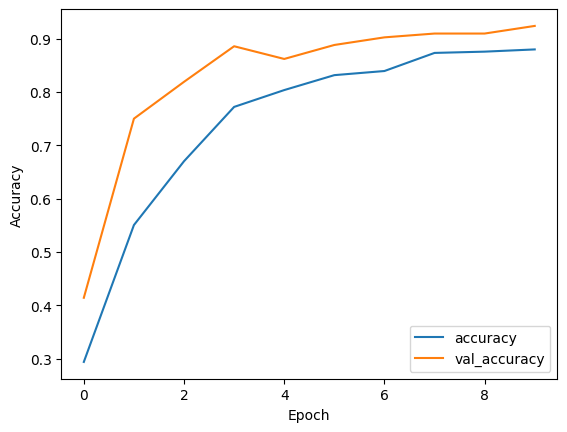

In [197]:
from keras.utils import to_categorical

# Convertendo os rótulos para one-hot encoding
y_train_one_hot = to_categorical(y_train, num_classes)
y_val_one_hot = to_categorical(y_val, num_classes)
y_test_one_hot = to_categorical(y_test, num_classes)

# Treinando o modelo
history = model.fit(X_train, y_train_one_hot, epochs=10, validation_data=(X_val, y_val_one_hot))

# Visualizando a curva de aprendizado
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()


### Evaluation

In [198]:
# Avaliação no conjunto de teste sem codificação one-hot
score = model.evaluate(X_test, y_test_one_hot, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

# Desfazendo a codificação one-hot para os rótulos de teste
y_test_decoded = np.argmax(y_test_one_hot, axis=1)

# Avaliação no conjunto de teste com os rótulos descodificados
score_decoded = model.evaluate(X_test, to_categorical(y_test_decoded, num_classes), verbose=0)
print("Test loss (decoded):", score_decoded[0])
print("Test accuracy (decoded):", score_decoded[1])


Test loss: 0.14038875699043274
Test accuracy: 0.9580952525138855
Test loss (decoded): 0.14038875699043274
Test accuracy (decoded): 0.9580952525138855


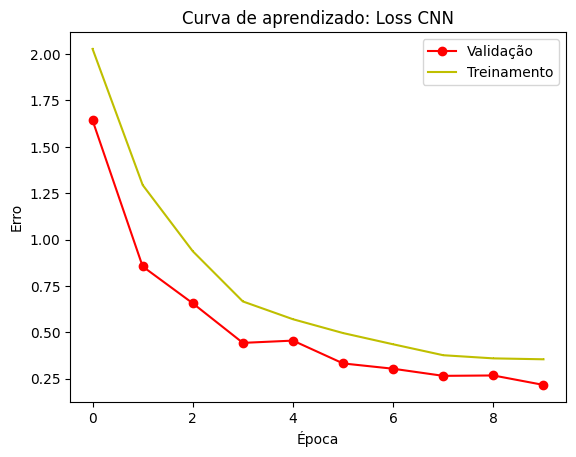

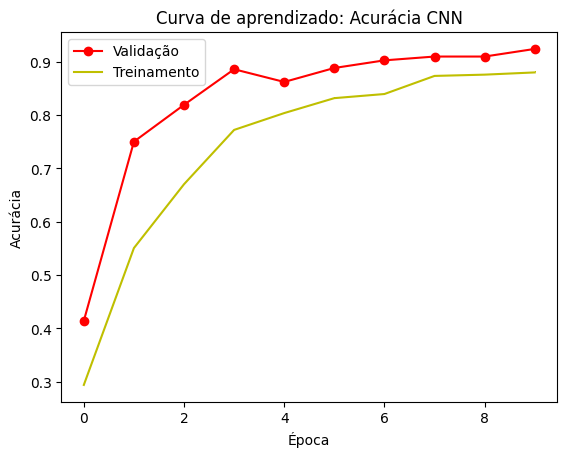

In [199]:
plt.figure()
plt.plot(history.epoch, history.history['val_loss'], 'o-r', label="Validação")
plt.plot(history.epoch, history.history['loss'],',-y', label="Treinamento")
plt.title("Curva de aprendizado: Loss CNN")
plt.xlabel("Época")
plt.ylabel("Erro")
plt.legend()

plt.figure()
plt.plot(history.epoch, history.history['val_accuracy'], 'o-r', label="Validação")
plt.plot(history.epoch, history.history['accuracy'],',-y', label="Treinamento")
plt.title("Curva de aprendizado: Acurácia CNN")
plt.xlabel("Época")
plt.ylabel("Acurácia")
plt.legend()


### Testing

66/66 [==============================] - 3s 38ms/step - loss: 0.1404 - accuracy: 0.9581
Test Loss: 0.14038875699043274
Test Accuracy: 0.9580952525138855
66/66 [==============================] - 3s 41ms/step


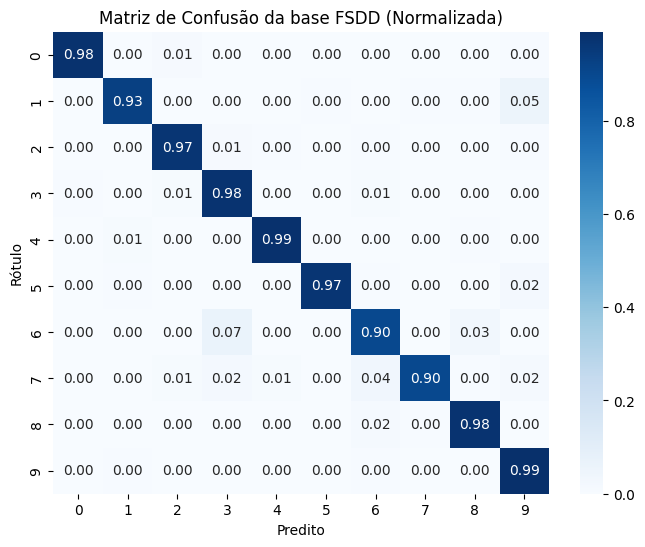

In [201]:
# Avaliação no conjunto de teste
score = model.evaluate(X_test, y_test_one_hot)
print("Test Loss:", score[0])
print("Test Accuracy:", score[1])

# Previsões no conjunto de teste
y_pred = model.predict(X_test)
predicted_labels = np.argmax(y_pred, axis=-1)
y_test_decoded = np.argmax(y_test_one_hot, axis=-1)

# Certifique-se de que y_test_decoded e predicted_labels têm o mesmo tamanho
min_size = min(len(y_test_decoded), len(predicted_labels))
y_test_decoded = y_test_decoded[:min_size]
predicted_labels = predicted_labels[:min_size]

# Matriz de Confusão
conf = confusion_matrix(y_test_decoded, predicted_labels)

# Normalização das colunas da matriz de confusão para melhor visualização das proporções
conf_norm = conf.astype('float') / conf.sum(axis=1)[:, np.newaxis]

# Visualização da Matriz de Confusão
plt.figure(figsize=(8, 6))
sns.heatmap(conf_norm, annot=True, fmt='.2f', cmap='Blues')
plt.xlabel('Predito')
plt.ylabel('Rótulo')
plt.title('Matriz de Confusão da base FSDD (Normalizada)')
plt.show()